In [10]:
import os
import glob
import nltk

def preprocess_text(text):
  text = text.lower()
  text = ''.join([c for c in text if c.isalnum() or c.isspace()])

  tokens = nltk.word_tokenize(text)
  stop_words = nltk.corpus.stopwords.words('english')
  tokens = [token for token in tokens if token not in stop_words]
    
  return tokens

folder_path = 'texts'

txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
words = []

for file_path in txt_files:
  with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
    tokens = preprocess_text(text)
    words.append(tokens)


In [15]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embeddings(lists_of_words):
    embeddings = []
    
    for words in lists_of_words:
        text = ' '.join(words)
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        last_hidden_states = outputs.last_hidden_state
        sentence_embedding = last_hidden_states.mean(dim=1)
        embeddings.append(sentence_embedding)
    return embeddings

embeddings = get_embeddings(words)

embeddings_np = [embedding.numpy() for embedding in embeddings]

for i, embed in enumerate(embeddings_np):
    print(f"Embeddings for list {i}: {embed.shape}\n{embed}\n")

Embeddings for list 0: (1, 768)
[[ 2.08036482e-01 -1.23949088e-01  2.30575070e-01  7.00121298e-02
   2.19887599e-01 -1.18544281e-01 -5.53295687e-02  2.52332807e-01
   3.81651428e-03 -1.33899957e-01 -1.15915539e-03 -2.06476152e-01
   2.57262215e-03  1.15353309e-01 -2.65213549e-01  4.15494919e-01
  -3.51914287e-01  1.50732920e-01  1.09993927e-01  1.46022215e-01
   2.53257990e-01 -1.94087774e-01  3.74079853e-01  8.77494365e-02
   4.40020800e-01 -3.61365736e-01  5.68863638e-02  1.17062241e-01
  -4.79474753e-01  1.67583935e-02  2.22627342e-01  1.88331440e-01
  -8.79214257e-02  2.25817375e-02  2.23392710e-01 -1.16262384e-01
   9.54577178e-02  6.65475950e-02 -6.39885440e-02  3.83463204e-02
  -3.71300280e-01 -4.23343182e-01 -1.26404867e-01 -1.28152296e-01
  -7.35771433e-02  3.66209410e-02  1.57306548e-02  1.45709872e-01
   2.20596686e-01 -1.59398615e-01 -3.79307210e-01  2.06933171e-01
  -2.66605288e-01 -3.04803908e-01 -1.97155494e-02  4.45841461e-01
   9.10586119e-02 -6.36165321e-01 -3.2700076

D:\anaconda\envs\LAD\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\LAD\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\LAD\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\LAD\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when

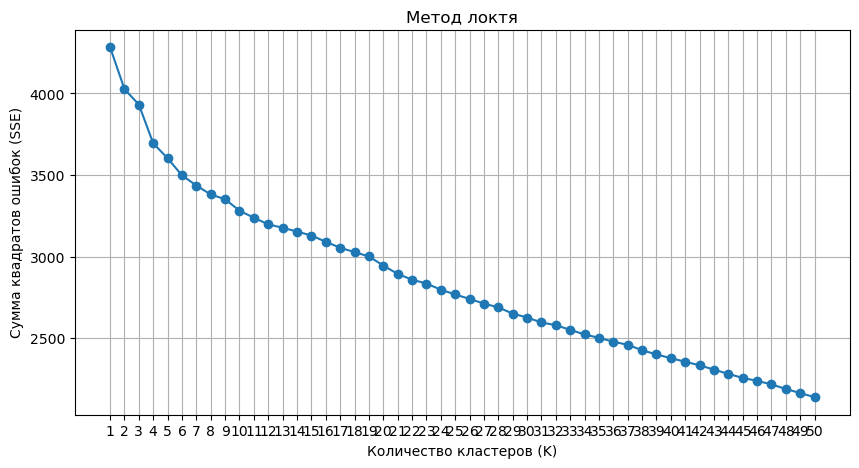

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

embeddings_array = np.array(embeddings_np, dtype=np.float64).squeeze()

def elbow_method(embeddings, max_k):
    sse = []
    
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)  
    return sse

max_k = 50

sse_values = elbow_method(embeddings_array, max_k)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_k + 1), sse_values, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

In [38]:
from sklearn.neighbors import NearestNeighbors
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings_array)

D:\anaconda\envs\LAD\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [39]:
def classify_new_document(new_text):
    new_embedding = get_embeddings([new_text])[0]
    cluster = kmeans.predict(new_embedding.reshape(1, -1))
    return cluster[0]

In [40]:
new_document = "Это новый документ для классификации."
predicted_cluster = classify_new_document(new_document)
print(f"Предсказанный кластер для нового документа: {predicted_cluster}")

Предсказанный кластер для нового документа: 1
